In [ ]:
from __future__ import unicode_literals
#from gensim.summarization import keywords
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pdb
import string
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import unicodedata
!pip install sumy
import re

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

df =pd.read_csv('./JD_DataScience_USA_small_1.csv', encoding= 'unicode_escape')
df1 = pd.read_csv('./Resume_DataScience_Updated_1.csv', encoding= 'unicode_escape')

jd = df['description'].tolist()
companies = df['company'].tolist()
positions = df['title'].tolist()
#print(jd[0])

resume = df1['Resume'].tolist()
#print(resume[0])




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cleanedjd = [x for x in jd if str(x) != 'nan']
cleanedresume = [x for x in resume if str(x) != 'nan']

cleanedjd.append(cleanedresume[0])


In [ ]:
print(cleanedjd[0])
print(cleanedjd[1])

As a Data Scientist at Meta, you will shape the future of people-facing and business-facing products we build across our entire family of applications (Facebook, Instagram, Messenger, WhatsApp, Oculus). By applying your technical skills, analytical mindset, and product intuition to one of the richest data sets in the world, you will help define the experiences we build for billions of people and hundreds of millions of businesses around the world. You will collaborate on a wide array of product and business problems with a diverse set of cross-functional partners across Product, Engineering, Research, Data Engineering, Marketing, Sales, Finance and others. You will use data and analysis to identify and solve product development??s biggest challenges. You will influence product strategy and investment decisions with data, be focused on impact, and collaborate with other teams. By joining Meta, you will become part of a world-class analytics community dedicated to skill development and 

In [ ]:
!pip install python-docx
!pip install fpdf



In [ ]:

model_names=['bert-base-nli-mean-tokens','roberta-base-nli-mean-tokens','distilbert-base-nli-mean-tokens']

In [ ]:
## 'bert-base-nli-cls-token-stsb-mean-tokens' ,

In [ ]:
### Easy — Sentence-Transformers
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

cosinesimilar = []
for model in model_names:
  model = SentenceTransformer(model)
  sentence_embeddings = model.encode(cleanedjd)
  sentence_embeddings.shape
  val = cosine_similarity([sentence_embeddings[0]],sentence_embeddings[1:])
  cosinesimilar.append(round(val[0, 0], 2))



In [ ]:
cosinesimilar

[0.58, 0.47, 0.6]

In [ ]:
ddf = pd.DataFrame({'model name': model_names, 'cosine similarity':cosinesimilar})
print(ddf)

                        model name  cosine similarity
0        bert-base-nli-mean-tokens               0.58
1     roberta-base-nli-mean-tokens               0.47
2  distilbert-base-nli-mean-tokens               0.60


In [ ]:
print(ddf)

                        model name  cosine similarity
0        bert-base-nli-mean-tokens               0.58
1     roberta-base-nli-mean-tokens               0.47
2  distilbert-base-nli-mean-tokens               0.60


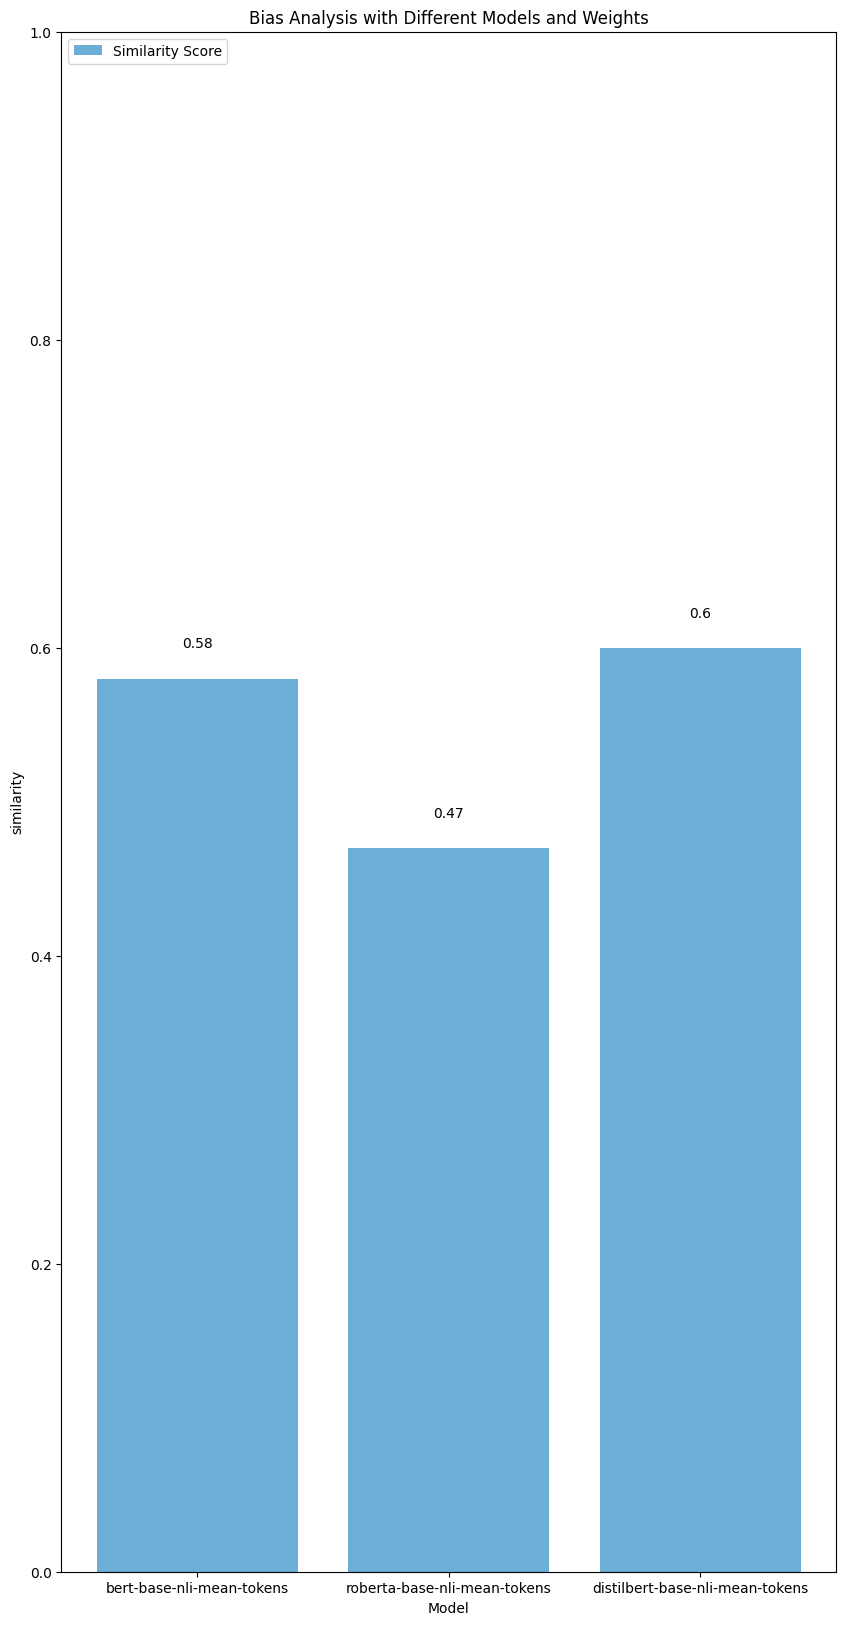

In [ ]:
import matplotlib.pyplot as plt

#models = ['BERT', 'DistilBERT', 'Word2vec']
#effect_sizes = [0.0034, 0.0075, 0.3288]
colors = ['#6baed6']

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 20))

# Create bars for effect size comparison
ax.bar(model_names,cosinesimilar,color=colors, label='Similarity Score')

# Add labels and ticks
ax.set_title('Bias Analysis with Different Models and Weights')
ax.set_xlabel('Model')
ax.set_ylabel('similarity')
ax.set_ylim([0, 1])

# Add annotations to the bars
for i, v in enumerate(cosinesimilar):
   ax.text(i, v + 0.02, str(v), ha='center')

# Add legend
ax.legend(loc='upper left')

# Show plot
plt.show()


In [ ]:
model_names=['sentence-transformers/bert-base-nli-mean-tokens','sentence-transformers/roberta-base-nli-mean-tokens',
'sentence-transformers/distilbert-base-nli-mean-tokens']

In [ ]:
### Involved — Transformers And PyTorch
from transformers import AutoTokenizer, AutoModel
import torch

cosinesimilarity = []
for models in model_names:

    tokenizer = AutoTokenizer.from_pretrained(models)
    model = AutoModel.from_pretrained(models)

    # initialize dictionary to store tokenized sentences
    tokens = {'input_ids': [], 'attention_mask': []}

    for sentence in cleanedjd:
        # encode each sentence and append to dictionary
        new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                          truncation=True, padding='max_length',
                                          return_tensors='pt')
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])

    # reformat list of tensors into single tensor
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

    outputs = model(**tokens)
    outputs.keys()

    embeddings = outputs.last_hidden_state
    print(embeddings)
    print(embeddings.shape)
    attention_mask = tokens['attention_mask']
    print(attention_mask.shape)
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    mask.shapemask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    print(mask.shape)
    print(mask)
    masked_embeddings = embeddings * mask
    print(masked_embeddings.shape)
    print(masked_embeddings)
    summed = torch.sum(masked_embeddings, 1)
    print(summed.shape)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    summed_mask.shape
    print(summed_mask)
    mean_pooled = summed / summed_mask
    print(mean_pooled)

    # convert from PyTorch tensor to numpy array
    mean_pooled = mean_pooled.detach().numpy()

    # calculate
    value =  cosine_similarity([mean_pooled[0]], mean_pooled[1:])
    cosinesimilarity.append(value[0, 0])


tensor([[[-0.5830,  1.0707,  0.5089,  ..., -1.2843, -0.4788,  0.0600],
         [-0.5386,  1.0882,  0.5930,  ..., -1.5719, -0.6880, -0.2322],
         [-0.7451,  0.7701,  0.7026,  ..., -1.3677, -0.5939,  0.0967],
         ...,
         [-0.3357,  0.9774,  0.7566,  ..., -0.9269, -0.8362,  0.0953],
         [-0.4598,  1.4239,  1.3379,  ..., -1.3289, -0.8957, -0.0091],
         [-0.7091,  1.1196,  0.6385,  ..., -1.2849, -0.6713,  0.0757]],

        [[-0.2581,  0.6002,  1.3699,  ..., -0.3237,  0.3338,  0.5696],
         [ 0.5765,  0.5863,  0.7291,  ...,  0.0323,  0.0021,  0.1463],
         [ 0.6443,  0.7493,  0.9976,  ...,  0.1743, -0.2027,  0.5044],
         ...,
         [-0.8457,  0.5690,  1.4381,  ...,  0.1321,  0.4753,  0.2773],
         [ 0.0783,  0.8094,  1.8094,  ...,  0.0163,  0.6064,  0.9887],
         [-0.1860,  0.9840,  1.4120,  ...,  0.0427,  0.0688,  0.4551]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([2, 128, 768])
torch.Size([2, 128])
torch.Size([2, 128, 768])


In [ ]:
cosinesimilarity

[0.5762189, 0.4656185, 0.5991588]

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define embeddings
#embeddings = np.array([[0.5, 0.2, 0.1], [0.1, 0.3, 0.4], [0.2, 0.3, 0.5], [0.4, 0.3, 0.2]])
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(cleanedjd)
print(sentence_embeddings.shape)
sims = cosine_similarity(sentence_embeddings)


# Compute cosine similarities
#sims = cosine_similarity(embeddings)

# Define target item
item_id = 0

# Find most similar items
similar_items = np.argsort(sims[item_id])[::-1]

# Print top 3 most similar items
for i in range(1, 2):
    print(f"Item {i}: Embedding: {sentence_embeddings[similar_items[i]]}, Cosine similarity: {sims[item_id][similar_items[i]]:.2f}")

(2, 384)
Item 1: Embedding: [-1.05127059e-01 -4.80157509e-02  6.10068021e-03 -1.80126652e-02
  1.13156578e-02 -7.03467727e-02 -5.00006005e-02  1.09942406e-02
 -6.16188832e-02  6.59272308e-03 -1.06781155e-01 -5.13623804e-02
  1.08681628e-02 -3.65057476e-02 -6.59758151e-02  3.27026844e-02
  4.52455599e-03 -4.29428890e-02 -9.33923572e-02 -1.31988645e-01
  1.56992059e-02  5.49951717e-02 -2.70325169e-02 -3.52138206e-02
  6.00790940e-02  1.31696509e-02  7.36271217e-02 -6.58681393e-02
 -4.02856506e-02 -1.29863867e-04  5.29626959e-05 -1.56067023e-02
  3.64672877e-02  5.64036444e-02 -6.80250004e-02  7.93213025e-02
 -4.32923883e-02  1.38941370e-02  4.48792093e-02 -2.22360622e-03
  2.48356424e-02 -7.24938959e-02  2.74740136e-03 -1.61461644e-02
  1.09107040e-01 -1.76090058e-02 -3.76970395e-02 -6.90247640e-02
  1.11221028e-02  2.09597051e-02 -1.12477712e-01  4.00535129e-02
 -3.45150344e-02  1.03552215e-01 -4.00081426e-02  1.49831548e-02
  8.10324401e-02 -4.06027809e-02 -3.57101369e-03  1.81043695e-